# Feature weight optimization 

**Goal:** "promote" the persistence of an $H_1$ feature by feature weighting.


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import importlib
import H1_optimizer
from ripser import ripser
import os
from tqdm import tqdm
from matplotlib import cm
from H1_optimizer import reweight_features_enhance_H1, one_step_reweight_enhance_H1
import importlib
import seaborn as sns
import pandas as pd
import gudhi
import dionysus
from scipy.spatial.distance import squareform, pdist

In [3]:
def get_cycle(X):
    '''
    Find a representative cycle for the most persistent H1 feature in point cloud X.
    '''
    M = pdist(X, metric='minkowski', p=1)

    f = dionysus.fill_rips(M, 2, M.max())
    f = dionysus.Filtration(f)  
    p = dionysus.homology_persistence(f)
    dgms = dionysus.init_diagrams(p, f)
    idx = np.argmax([y.death - y.birth for y in dgms[1]])
    pt = dgms[1][idx]
    print(idx, pt)
    x = p.pair(pt.data)
    cycle = []
    for sei in p[x]:
        s = f[sei.index]    # simplex
        cycle.append([int(v) for v in s])
        print('#',s)

    return cycle

## Noisy periodic multivariate time series

Reproducing P. Bubenik and J. Bush, _Topological feature selection for time series data_

In [4]:
def create_time_series_data(save_plots=False, base_seed=None, trial=0, phase_spacing=False, sliding_window_size=250):
    if base_seed is not None:
        np.random.seed(base_seed)
    if not phase_spacing:
        K = np.random.random(size=10)*50
    else:
        K = np.array(list(np.linspace(0, 50, 3, endpoint=False)) + list(np.random.random(size=7)*50))
    t = np.arange(0,300)
    f = np.sin(2*np.pi/50*(t[:,None]-K[None,:]))
    if save_plots:
        fig, ax = plt.subplots(len(K), figsize=(8,5))
        for i in range(K.shape[0]):
            ax[i].plot(f[:,i], color=cm.tab10(i))
            ax[i].set_yticks([])
        plt.savefig('figs/sine_waves_pure.png', bbox_inches='tight', dpi=300)
        plt.close()

    shuffle_fs = []
    for i in range(f.shape[1]):
        if i > 2:
            shuffle_f = np.random.permutation(f[:,i])
        else:
            shuffle_f = f[:,i]
        shuffle_fs.append(shuffle_f)
    if save_plots:
        fig, ax = plt.subplots(len(K), figsize=(8,5))
        for i in range(K.shape[0]):
            ax[i].scatter(range(shuffle_fs[i].shape[0]), shuffle_fs[i], color=cm.tab10(i), s=2)
            ax[i].set_yticks([])
        plt.savefig('figs/sine_waves_shuffled.png', bbox_inches='tight', dpi=300)
        plt.close()

    noise_fs = shuffle_fs + np.random.normal(scale=1.5, size=np.array(shuffle_fs).shape)
    if save_plots:
        fig, ax = plt.subplots(len(K), figsize=(8,5))
        for i in range(K.shape[0]):
            ax[i].scatter(range(noise_fs[i].shape[0]), noise_fs[i], color=cm.tab10(i), s=2)
            ax[i].set_yticks([])
        plt.savefig('figs/sine_waves_noisy.png', bbox_inches='tight', dpi=300)
        plt.close()

    if trial is not None:
        np.random.seed(trial)
        noise_fs = noise_fs + np.random.normal(scale=0.1, size=np.array(noise_fs).shape)

    X = np.array([
        noise_fs[:,j:j+sliding_window_size].ravel() for j in range(noise_fs.shape[1]-sliding_window_size+1) 
    ])
    feature_labels = np.array([
        i for i in range(noise_fs.shape[0]) for j in range(sliding_window_size)
    ])

    return X, feature_labels


In [5]:
# Generate the data
np.random.seed(2025)
sliding_window_size = 250
phase_spacing = False
X_list = []
for trial in range(10):
    X, _ = create_time_series_data(save_plots=(trial==0), base_seed=None, trial=None, phase_spacing=phase_spacing, sliding_window_size=sliding_window_size)
    X_list.append(X)

In [10]:
# Test methods on the data

np.random.seed(2025)
reg = 0
T_onestep_list = []
T_simplices_list = []
T_cochains_list = []
p_onestep_list = []
p_simplices_list = []
p_cochains_list = []
p_original_list = []

for trial in range(10):
    print('Trial ', trial)
    X = X_list[trial]
    Y_original = X.copy() / 10
    PD = ripser(np.linalg.norm(Y_original[:,None,:] - Y_original[None,:,:], axis=-1, ord=1), maxdim=1, distance_matrix=True)['dgms'][1]
    persistence = sorted(PD, key=lambda x: -x[0] + x[1], reverse=True)
    p_original_list.append(persistence[0][1] - persistence[0][0])
    
    print('One step cochains:')
    A = np.kron(np.eye(10), np.ones((1, sliding_window_size)))
    T_onestep = one_step_reweight_enhance_H1(
        X, A=A, method='cochains', epsilon=[0.01, 0.05, 0.1]
    )
    T_onestep_list.append(T_onestep)
    print('Simplices:')
    T_simplices = reweight_features_enhance_H1(
        X, A=A, method='single_edges', gamma=2**(-6)/10, max_iter=5, log=False, tol=0, regularization=reg
    )
    T_simplices_list.append(T_simplices)
    print('(Multi)cochains:')
    T_cochains = reweight_features_enhance_H1(
        X, A=A, method='cochains', gamma=2**(-6)/10, max_iter=5, log=False, epsilon=[0.01, 0.05, 0.1], tol=0, regularization=reg
    )
    T_cochains_list.append(T_cochains)

    Y_simplices = (T_simplices @ A)*X
    PD = ripser(np.linalg.norm(Y_simplices[:,None,:] - Y_simplices[None,:,:], axis=-1, ord=1), maxdim=1, distance_matrix=True)['dgms'][1]
    persistence = sorted(PD, key=lambda x: -x[0] + x[1], reverse=True)
    p_simplices_list.append(persistence[0][1] - persistence[0][0])

    Y_onestep = (T_onestep @ A)*X
    PD = ripser(np.linalg.norm(Y_onestep[:,None,:] - Y_onestep[None,:,:], axis=-1, ord=1), maxdim=1, distance_matrix=True)['dgms'][1]
    persistence = sorted(PD, key=lambda x: -x[0] + x[1], reverse=True)
    p_onestep_list.append(persistence[0][1] - persistence[0][0])

    Y_cochains = (T_cochains @ A)*X
    PD = ripser(np.linalg.norm(Y_cochains[:,None,:] - Y_cochains[None,:,:], axis=-1, ord=1), maxdim=1, distance_matrix=True)['dgms'][1]
    persistence = sorted(PD, key=lambda x: -x[0] + x[1], reverse=True)
    p_cochains_list.append(persistence[0][1] - persistence[0][0])

Trial  0
One step cochains:


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


Simplices:


100%|██████████| 5/5 [00:00<00:00, 26.03it/s]


(Multi)cochains:


100%|██████████| 5/5 [00:01<00:00,  2.78it/s]


Trial  1
One step cochains:


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]


Simplices:


100%|██████████| 5/5 [00:00<00:00, 34.45it/s]


(Multi)cochains:


100%|██████████| 5/5 [00:01<00:00,  2.96it/s]


Trial  2
One step cochains:


  0%|          | 0/1 [00:00<?, ?it/s]

Need to fix integer lift...  41.0  != 0
[-13  14 -14 ...   0  14 -14]
Fixed lift to now have coboundary at most 0.0
Adjusting alpha to be zero before birth time
Alpha adjusted to be at most  2.3715248431699365e-05 before birth time.
Need to fix integer lift...  41.0  != 0
[-13  14 -14 ...   0  14 -14]
Fixed lift to now have coboundary at most 0.0
Adjusting alpha to be zero before birth time
Alpha adjusted to be at most  8.902453108738939e-05 before birth time.


100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Need to fix integer lift...  41.0  != 0
[-13  14 -14 ...   0  14 -14]
Fixed lift to now have coboundary at most 0.0
Adjusting alpha to be zero before birth time
Alpha adjusted to be at most  1.4210854715202004e-14 before birth time.
Simplices:


100%|██████████| 5/5 [00:00<00:00, 34.27it/s]


(Multi)cochains:


  0%|          | 0/5 [00:00<?, ?it/s]

Need to fix integer lift...  41.0  != 0
[-13  14 -14 ...   0  14 -14]
Fixed lift to now have coboundary at most 0.0
Adjusting alpha to be zero before birth time
Alpha adjusted to be at most  2.3715248431699365e-05 before birth time.
Need to fix integer lift...  41.0  != 0
[-13  14 -14 ...   0  14 -14]
Fixed lift to now have coboundary at most 0.0
Adjusting alpha to be zero before birth time
Alpha adjusted to be at most  8.902453108738939e-05 before birth time.


 20%|██        | 1/5 [00:00<00:02,  1.44it/s]

Need to fix integer lift...  41.0  != 0
[-13  14 -14 ...   0  14 -14]
Fixed lift to now have coboundary at most 0.0
Adjusting alpha to be zero before birth time
Alpha adjusted to be at most  1.4210854715202004e-14 before birth time.


100%|██████████| 5/5 [00:01<00:00,  2.74it/s]


Trial  3
One step cochains:


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Simplices:


100%|██████████| 5/5 [00:00<00:00, 35.07it/s]


(Multi)cochains:


100%|██████████| 5/5 [00:01<00:00,  3.13it/s]


Trial  4
One step cochains:


100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


Simplices:


100%|██████████| 5/5 [00:00<00:00, 27.31it/s]


(Multi)cochains:


 40%|████      | 2/5 [00:00<00:01,  2.66it/s]

Need to fix integer lift...  41.0  != 0
[ 20   0 -20 ...  20   0  20]
Fixed lift to now have coboundary at most 0.0
Adjusting alpha to be zero before birth time
Alpha adjusted to be at most  0.00011750625108186696 before birth time.
Need to fix integer lift...  41.0  != 0
[ 20   0 -20 ...  20   0  20]
Fixed lift to now have coboundary at most 0.0


 60%|██████    | 3/5 [00:01<00:00,  2.50it/s]

Need to fix integer lift...  41.0  != 0
[ 20   0 -20 ...  20   0  20]
Fixed lift to now have coboundary at most 0.0
Need to fix integer lift...  41.0  != 0
[ 20   0 -20 ...  20   0  20]
Fixed lift to now have coboundary at most 0.0
Adjusting alpha to be zero before birth time
Alpha adjusted to be at most  0.00042364434257535777 before birth time.
Need to fix integer lift...  41.0  != 0
[ 20   0 -20 ...  20   0  20]
Fixed lift to now have coboundary at most 0.0
Adjusting alpha to be zero before birth time
Alpha adjusted to be at most  2.842170943040401e-14 before birth time.


 80%|████████  | 4/5 [00:01<00:00,  2.37it/s]

Need to fix integer lift...  41.0  != 0
[ 20   0 -20 ...  20   0  20]
Fixed lift to now have coboundary at most 0.0
Adjusting alpha to be zero before birth time
Alpha adjusted to be at most  7.105427357601002e-15 before birth time.
Need to fix integer lift...  41.0  != 0
[-20   0  20 ... -20   0 -20]
Fixed lift to now have coboundary at most 0.0
Adjusting alpha to be zero before birth time
Alpha adjusted to be at most  0.00047090875622046724 before birth time.
Need to fix integer lift...  41.0  != 0
[-20   0  20 ... -20   0 -20]
Fixed lift to now have coboundary at most 0.0


100%|██████████| 5/5 [00:02<00:00,  2.34it/s]

Need to fix integer lift...  41.0  != 0
[-20   0  20 ... -20   0 -20]
Fixed lift to now have coboundary at most 0.0


Trial  5
One step cochains:


100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


Simplices:


100%|██████████| 5/5 [00:00<00:00, 33.66it/s]


(Multi)cochains:


100%|██████████| 5/5 [00:01<00:00,  3.08it/s]


Trial  6
One step cochains:


100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


Simplices:


100%|██████████| 5/5 [00:00<00:00, 35.19it/s]


(Multi)cochains:


100%|██████████| 5/5 [00:01<00:00,  2.76it/s]


Trial  7
One step cochains:


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]


Simplices:


100%|██████████| 5/5 [00:00<00:00, 31.49it/s]


(Multi)cochains:


100%|██████████| 5/5 [00:01<00:00,  3.33it/s]


Trial  8
One step cochains:


100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


Simplices:


100%|██████████| 5/5 [00:00<00:00, 37.63it/s]


(Multi)cochains:


100%|██████████| 5/5 [00:01<00:00,  3.53it/s]


Trial  9
One step cochains:


100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


Simplices:


100%|██████████| 5/5 [00:00<00:00, 37.03it/s]


(Multi)cochains:


100%|██████████| 5/5 [00:01<00:00,  3.17it/s]

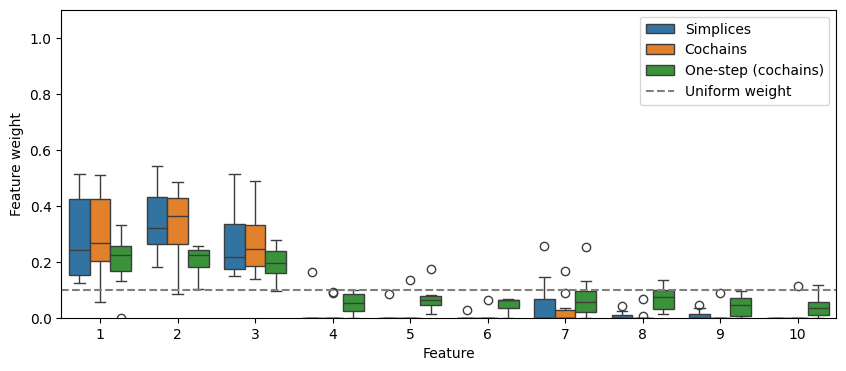

In [11]:
# Organize results into a DataFrame for plotting
T_simplices_df = pd.DataFrame(np.array(T_simplices_list), columns=[f'{i+1}' for i in range(10)])
T_cochains_df = pd.DataFrame(np.array(T_cochains_list), columns=[f'{i+1}' for i in range(10)])
T_onestep_df = pd.DataFrame(np.array(T_onestep_list), columns=[f'{i+1}' for i in range(10)])
T_simplices_df['method'] = 'Simplices'
T_cochains_df['method'] = 'Cochains'
T_onestep_df['method'] = 'One-step (cochains)'
all_weights_df = pd.concat([T_simplices_df, T_cochains_df, T_onestep_df], ignore_index=True)

# Plot results
plt.subplots(figsize=(10,4))
sns.boxplot(data=all_weights_df.melt(id_vars=['method']), x='variable', y='value', hue='method')
plt.ylabel('Feature weight')
plt.ylim(0,1.1)
plt.xlabel('Feature')
plt.gca().axhline(y=1.0/10, color='gray', linestyle='--', label='Uniform weight')
plt.legend()
plt.savefig('figs/feature_weights_boxplot.png', bbox_inches='tight', dpi=300)
plt.show()

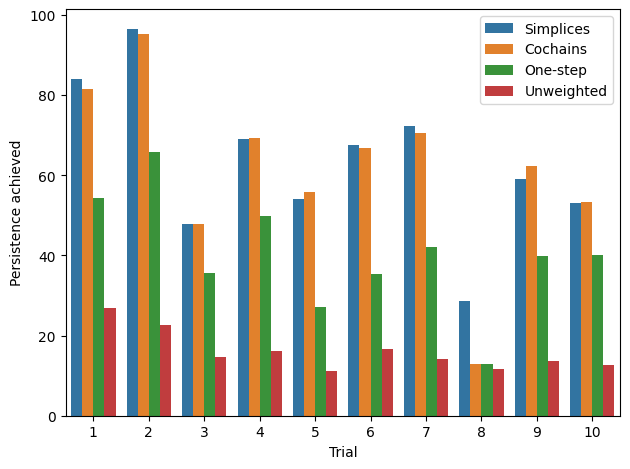

In [16]:
# Plot persistence comparison
import seaborn as sns
import pandas as pd

# Create a dataframe for Seaborn
data = pd.DataFrame({
    'Trial': np.tile(np.arange(10) + 1, 4),
    'Persistence': np.concatenate([p_simplices_list, p_cochains_list, p_onestep_list, p_original_list]),
    'Method': ['Simplices'] * 10 + ['Cochains'] * 10 + ['One-step'] * 10 + ['Unweighted'] * 10
})

# Create the grouped bar plot
sns.barplot(data=data, x='Trial', y='Persistence', hue='Method')
plt.ylabel('Persistence achieved')
plt.xlabel('Trial')
plt.legend()
plt.tight_layout()

0 (4530.99,4648.09)
# <49,50> 4493.31
# <48,49> 4501.48
# <47,48> 4503.2
# <46,47> 4509.29
# <45,46> 4518.45
# <44,45> 4519.35
# <44,50> 4530.99


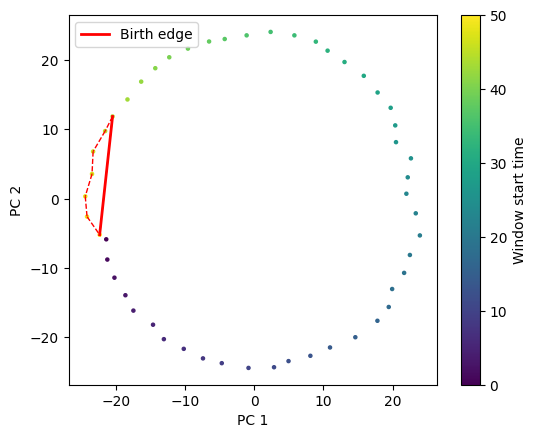

In [17]:
# Look at the cycle in Trial 7 to explain results
trial = 7
cycle_points = get_cycle(X_list[trial])
M = np.linalg.norm(X_list[7][:, np.newaxis, :] - X_list[7][np.newaxis, :, :], axis=-1, ord=1)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
Y7 = pca.fit_transform(X_list[trial])
birth_edge = cycle_points[np.argmax([M[i,j] for i, j in cycle_points])]

for i, j in cycle_points:
    plt.plot([Y7[i,0], Y7[j,0]], [Y7[i,1], Y7[j,1]], color='red', linewidth=1, linestyle='--')
plt.plot(Y7[birth_edge,0], Y7[birth_edge,1], color='red', linewidth=2, label='Birth edge')
plt.scatter(Y7[:,0], Y7[:,1], s=5, c=range(Y7.shape[0]), cmap='viridis')
plt.colorbar(label='Window start time')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()
plt.gca().set_aspect('equal', 'box')
plt.savefig('figs/trial7_cycle_points.png', bbox_inches='tight', dpi=300)
plt.show()

## Arctic Ice

In [75]:
folder_prefix = '/Users/t_weighill/Documents/Mentoring/Jocelyn/daacdata.apps.nsidc.org/pub/DATASETS/nsidc0265_QuikSCAT_ice_extent/data/north/binary/eggs'

In [76]:
from loadsir import loadsir
def reduce_image(img, scale=30):
    rows, cols = int(img.shape[0]/scale), int(img.shape[1]/scale)
    rimg = np.zeros((rows, cols))
    for i in range(rows):
        for j in range(cols):
            rimg[i,j] = np.sum(img[i*scale:(i+1)*scale, j*scale:(j+1)*scale])
    return rimg

all_eggs = []
for year in range(1999, 2010):
    eggs = []
    days = []
    for file in tqdm(sorted(os.listdir('{}/{}'.format(folder_prefix, year)))):
        #print('ice/{}/'.format(year) + file)
        sir = loadsir('{}/{}/'.format(folder_prefix, year) + file)
        binary_img = np.array(np.abs(np.abs(sir[0] - 1) < 1e-2), dtype= int)
        eggs.append(reduce_image(binary_img))
        days.append(file.split('.')[0][-3:])

    X = np.array([e.ravel() for e in eggs])
    X = X/X.max()
    all_eggs.append(X)

100%|██████████| 327/327 [00:14<00:00, 23.07it/s]


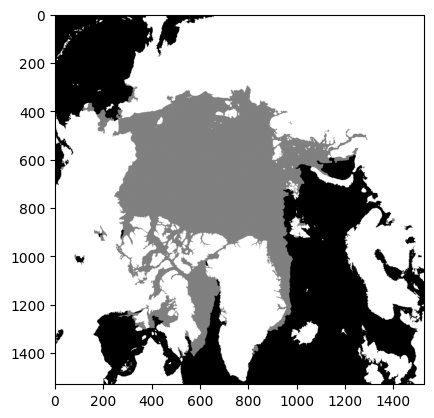

In [77]:
plt.imshow(sir[0], cmap='gray')

In [ ]:
for year, X in enumerate(all_eggs):
    PD = ripser(X, maxdim=1, metric='manhattan')['dgms'][1]
    plt.scatter(PD[:,0], PD[:,1])
    plt.plot([0,110],[0,110], 'k--')
    plt.xlim([0,110])
    plt.ylim([0,110])
    plt.gca().set_aspect('equal', 'box')
    plt.xlabel('birth')
    plt.ylabel('death')
    plt.title('{}'.format(year+1999))
    plt.savefig('ice_eggs_{}_PD.png'.format(year+1999), bbox_inches='tight', dpi=300)
    plt.close()

/opt/miniconda3/envs/work311/lib/python3.11/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/opt/miniconda3/envs/work311/lib/python3.11/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/opt/miniconda3/envs/work311/lib/python3.11/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/opt/miniconda3/envs/work311/lib/python3.11/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/opt/miniconda3/envs/work311/lib/python3.11/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/opt/miniconda3/envs/work311/lib/python3.11/site-packages/ripser/

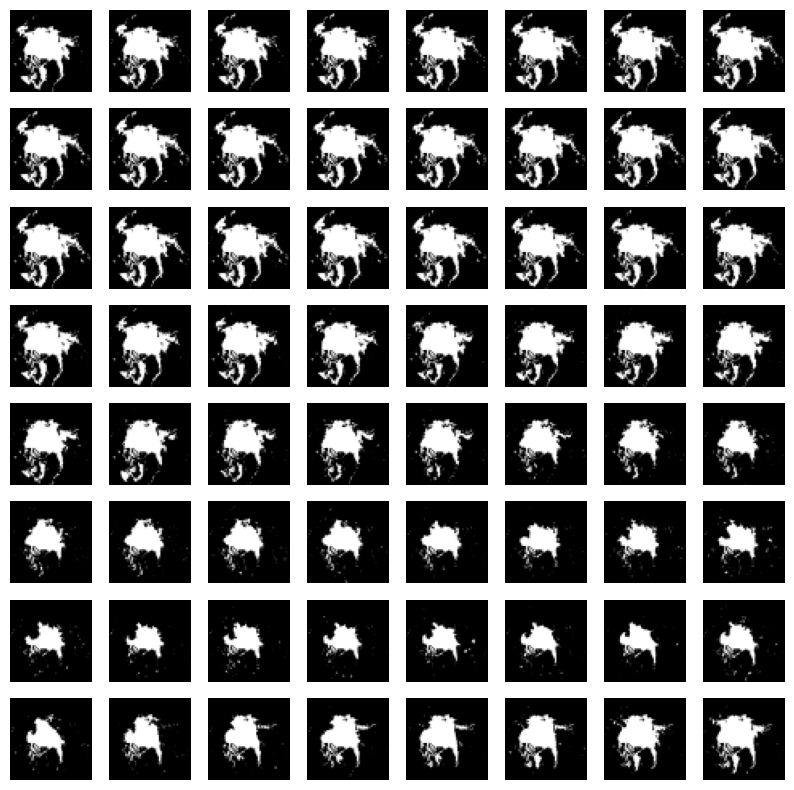

In [78]:
X = all_eggs[7] # 2006 data

fig, ax = plt.subplots(8,8, figsize=(10,10))
idxs = np.linspace(0, len(eggs)-1, 64, dtype=int)
for i in range(8):
    for j in range(8):
        ax[i,j].axis('off')
        ax[i,j].imshow(eggs[idxs[i*8+j]], cmap='gray')

plt.savefig('ice_eggs_2006.png', bbox_inches='tight', dpi=300)

100%|██████████| 1/1 [02:28<00:00, 148.66s/it]


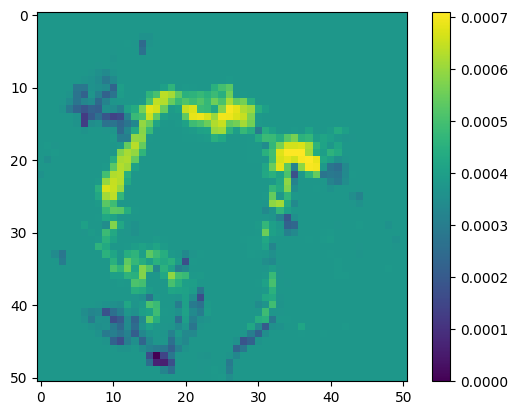

In [79]:
importlib.reload(H1_optimizer)
from H1_optimizer import one_step_reweight_enhance_H1
T = one_step_reweight_enhance_H1(X, method='harmonic', epsilon=[0.01, 0.05, 0.1])


plt.imshow(T.reshape(eggs[0].shape), cmap='viridis')
plt.colorbar()
plt.savefig('ice_eggs_2006_weights.png', bbox_inches='tight', dpi=300)
plt.show()

Explained variance ratios: [0.61617386 0.10212691]


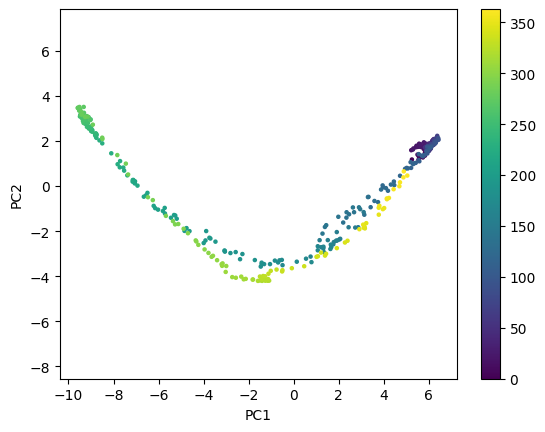

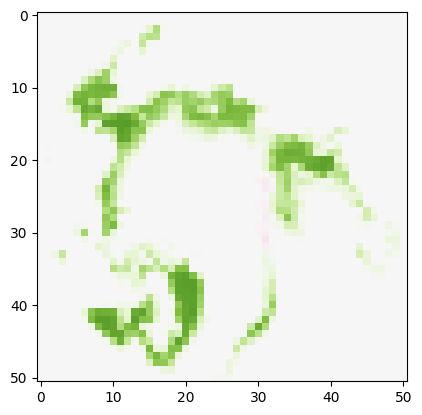

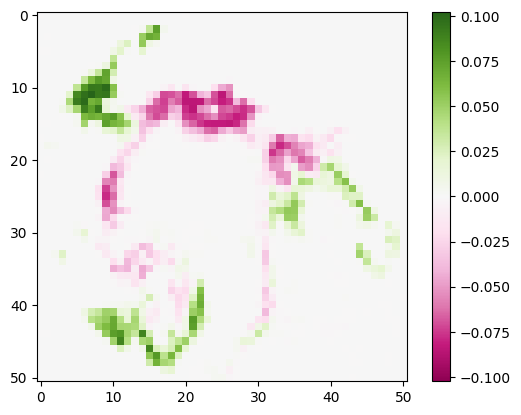

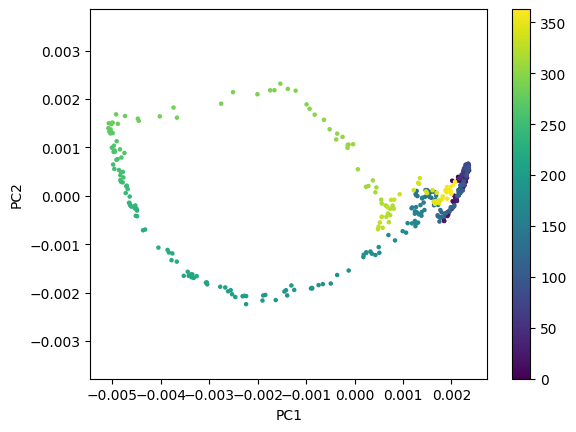

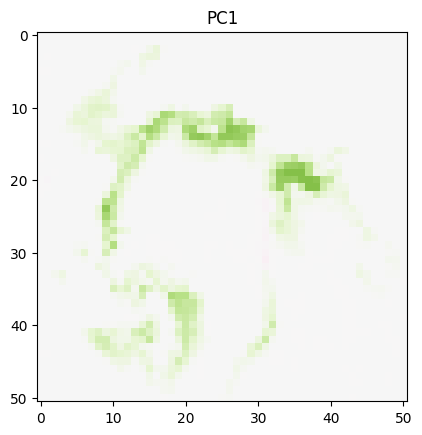

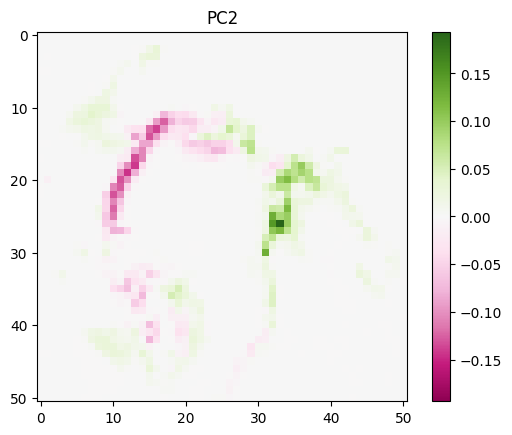

ValueError: operands could not be broadcast together with shapes (10,) (364,2601) 

In [81]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
A = pca.fit_transform(X)
loadings = pca.components_.T
print('Explained variance ratios:', pca.explained_variance_ratio_)
plt.scatter(A[:,0], A[:,1], s=5, c=range(A.shape[0]))
plt.colorbar()
plt.axis('equal')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.savefig('ice_eggs_2006_PCA_uniform.png', bbox_inches='tight', dpi=300)
plt.show()
limit = np.max(np.abs(loadings))
plt.imshow(loadings[:,0].reshape(eggs[0].shape), cmap='PiYG', vmin=-limit, vmax=limit)
plt.savefig('ice_eggs_2006_PC1_uniform.png', bbox_inches='tight', dpi=300)
plt.show()
plt.imshow(loadings[:,1].reshape(eggs[0].shape), cmap='PiYG', vmin=-limit, vmax=limit)
#colorbar
plt.colorbar()
plt.savefig('ice_eggs_2006_PC2_uniform.png', bbox_inches='tight', dpi=300)
plt.show()

pca = PCA(n_components=2)
A = pca.fit_transform(T*X)
loadings = pca.components_.T
plt.scatter(A[:,0], A[:,1], s=5, c=range(A.shape[0]))
plt.colorbar()
plt.axis('equal')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.savefig('ice_eggs_2006_PCA_learned.png', bbox_inches='tight', dpi=300)
plt.show()
limit = np.max(np.abs(loadings))
plt.imshow(loadings[:,0].reshape(eggs[0].shape), cmap='PiYG', vmin=-limit, vmax=limit)
plt.title('PC1')
plt.savefig('ice_eggs_2006_PC1_learned.png', bbox_inches='tight', dpi=300)
plt.show()
plt.imshow(loadings[:,1].reshape(eggs[0].shape), cmap='PiYG', vmin=-limit, vmax=limit)
plt.title('PC2')
#colorbar
plt.colorbar()
plt.savefig('ice_eggs_2006_PC2_learned.png', bbox_inches='tight', dpi=300)
plt.show()

pca = PCA(n_components=2)
A = pca.fit_transform(T_simplices*X)
loadings = pca.components_.T
plt.scatter(A[:,0], A[:,1], s=5, c=range(A.shape[0]))
plt.colorbar()
plt.axis('equal')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.savefig('ice_eggs_2006_PCA_learned_simplices.png', bbox_inches='tight', dpi=300)
plt.show()
limit = np.max(np.abs(loadings))
plt.imshow(loadings[:,0].reshape(eggs[0].shape), cmap='PiYG', vmin=-limit, vmax=limit)
plt.title('PC1')
plt.savefig('ice_eggs_2006_PC1_learned_simplices.png', bbox_inches='tight', dpi=300)
plt.show()
plt.imshow(loadings[:,1].reshape(eggs[0].shape), cmap='PiYG', vmin=-limit, vmax=limit)
plt.title('PC2')
#colorbar
plt.colorbar()
plt.savefig('ice_eggs_2006_PC2_learned_simplices.png', bbox_inches='tight', dpi=300)
plt.show()

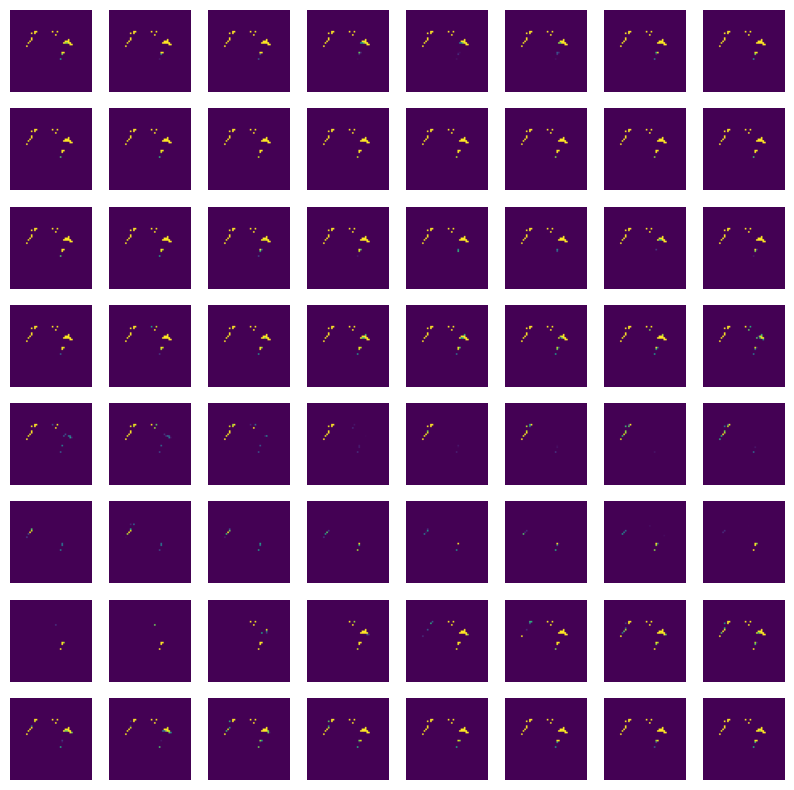

In [ ]:
mask = (Tguess >= np.quantile(Tguess, 0.99)).reshape(eggs[0].shape)
plt.imshow(mask, cmap='gray')

fig, ax = plt.subplots(8,8, figsize=(10,10))
idxs = np.linspace(0, len(eggs)-1, 64, dtype=int)
for i in range(8):
    for j in range(8):
        ax[i,j].axis('off')
        ax[i,j].imshow(mask*eggs[idxs[i*8+j]], cmap='viridis')

In [82]:
importlib.reload(H1_optimizer)
from H1_optimizer import reweight_features_enhance_H1
T_simplices = reweight_features_enhance_H1(X, method='single_edges', gamma = 0.01, max_iter=1000)


plt.imshow(T_simplices.reshape(eggs[0].shape), cmap='viridis')
plt.colorbar()
plt.savefig('ice_eggs_2006_weights_simplices.png', bbox_inches='tight', dpi=300)
plt.show()

  0%|          | 4/1000 [00:16<1:06:34,  4.01s/it]


KeyboardInterrupt: 